# BCI Take Home Assignment

In [212]:
import pandas as pd
import yfinance as yf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# Loading the data
load the data: Daily Close prices (in USD) for AAPL, AMZN, GOOG, INTC, ORCL, XOM, CVX, COP, HES, OXY
Assumption: I will use the close price instead of the adjusted close price for this study

In [7]:
# Pre-loading the data: Daily Close prices (in USD) for AAPL, AMZN, GOOG, INTC, ORCL, XOM, CVX, COP, HES, OXY
# assumption: I will assume the close price in this study is the close price not the adjusted close price

def fetch_data(stocks, start_date, end_date):
    """
    Parameters:
    - stocks: List of stock ticker symbols
    - start_date: Start date ('YYYY-MM-DD' format)
    - end_date: End date ('YYYY-MM-DD' format)
    """

    # initialize dataframe
    close_df = pd.DataFrame()

    # get all the prices we need
    for stock in stocks:
        stock_data = yf.download(stock, start=start_date, end=end_date)
        close_df[stock] = stock_data['Close']

    return close_df

# The stocks and the timeframe that we will look into in this assignment
stocks = ["AAPL", "AMZN", "GOOG", "INTC", "ORCL", "XOM", "CVX", "COP", "HES", "OXY"]
start_date, end_date = "2012-01-01","2021-12-31"

# the stocks price data for the 10 tickers given above from 2012-01-01 to 2021-12-31
close_df = fetch_data(stocks, start_date, end_date)
close_df.head(5)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,AMZN,GOOG,INTC,ORCL,XOM,CVX,COP,HES,OXY
Date,,,,,,,,,,
2012-01-03,14.686786,8.9515,16.573130,24.540001,25.860001,86.000000,110.370003,56.541019,58.400002,92.577477
2012-01-04,14.765714,8.8755,16.644611,25.110001,26.010000,86.019997,110.180000,56.274208,59.000000,92.855316
2012-01-05,14.929643,8.8805,16.413727,25.400000,26.590000,85.760002,109.099998,55.824444,57.599998,92.117607
2012-01-06,15.085714,9.1305,16.189817,25.250000,26.930000,85.120003,108.309998,55.389919,56.419998,91.753540
2012-01-09,15.061786,8.9280,15.503389,25.469999,27.030001,85.500000,109.489998,55.603371,56.900002,92.864891


# Q1: Generate daily returns using the Close prices over this period for AAPL. Are the daily returns normally distributed? Provide some evidence to support your answer.

$$r_{i}^{per} = \frac{Price_{i}}{Price_{i-1}}-1$$
$r_i^{per}$: the return at ith day based on the percentage change \
$Price_i$: the close price at ith day \
$Price_{i-1}$: the close price at i-1 th day

$$r_{i}^{log} = log(\frac{Price_{i}}{Price_{i-1}})$$
$r_i^{per}$: the return at ith day based on the percentage change \
$Price_i$: the close price at ith day \
$Price_{i-1}$: the close price at i-1 th day


Assumption: The returns can be the simple return and the log-return, and log-return is what we normally use in practice for the nature of addictivity. So I will use log-return for the study

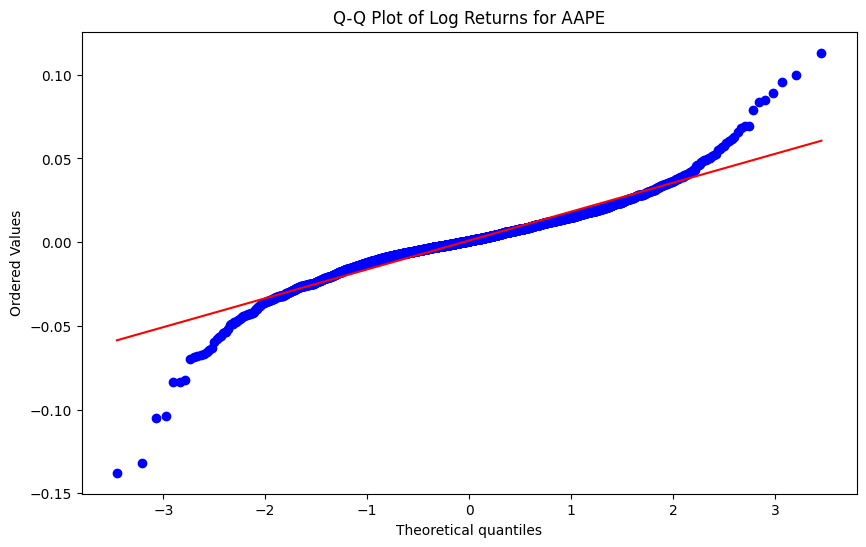

Shapiro-Wilk Test on Log Returns for AAPL:
Statistic: 0.9288885181272837, P-value: 5.3708145506988486e-33
Reject the null hypothesis: the data is not normally distributed.


In [10]:

# Log Return of Apple
Apple_Return = np.log(close_df.AAPL) - np.log(close_df.AAPL.shift(1))
# Note: the return for day 1 (2012-01-01) should be zero since we dont have the prior data for the first day
Apple_Return = Apple_Return[1:]

# Normality test. We will go from two ways:
## 1. identify by Visual Test
# Plot Q-Q plot
# We do not standardize the returns since we do not need to compare with other return.
plt.figure(figsize=(10, 6))
stats.probplot(Apple_Return, dist="norm", plot=plt)
plt.title((f'Q-Q Plot of Log Returns for {"AAPE"}'))
plt.show()

## 2. identify by the Hypothesis Testing
# Conduct Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(Apple_Return)
print(f"Shapiro-Wilk Test on Log Returns for {'AAPL'}:")
print(f"Statistic: {shapiro_test[0]}, P-value: {shapiro_test[1]}")

# Interpretation of the Shapiro-Wilk test: I will assume 95%
# confidence interval as the rejection criteria for this question
if shapiro_test[1] > 0.05:
    print("Fail to reject the null hypothesis: the data is normally distributed.")
else:
    print("Reject the null hypothesis: the data is not normally distributed.")





## Answer: 
The Q-Q plot indicates that the log returns for AAPE deviate from a normal distribution, which has fatter tails. This aligns with the stylized facts of financial data, where extreme movements are more common than a normal distribution would predict. From the Shapiro-Wilk test, the p-value is way lower than 0.05, which shows strong evidence to reject the null hypothesis that the returns follow the normal distribution, so we can conclude that the return is not normally distributed

# Q2: A colleague is interested in creating a model to predict the future price of AAPL stock using ordinary least squares to regress the price on day t on the price at day t-1 and a constant: $P_t = a + b p_{t-1} + e_t$ Is this a suitable model to predict the future price of AAPL? Do you think OLS is appropriate for estimating the parameters a and b? If so, estimate the parameters a and b using your data. If not, please explain why it is inappropriate.

# Answer
First, the model can be interpreted as a simple linear regression. For the simple linear regression, the basic assumption is the linearity between the predictor and the dependent variable, which is the previous day's price and the current day's price. But for the stylized facts for the financial data, we will assume the price chance follows the random walk, and also the price change does not have the constant variance which violates the assumptions of homoscedasticity. 
Second, if he considered using the AR(1) model to conduct the forecasting, which involves the choice of the previous day's price. Then there are many concerns he should care about: 1. The stationarity of the stock data will be violated depending on the interval of the training set. 2. assume he wants to use the AR(1) with non-zero mean, he is model should be in the form $p_t-\mu=\phi(p_{t-1}-\mu)+\epsilon_t$.  
OLS is not a good estimate for a and b in this model, one of the key reasons is that we just mention that the error term does not have a constant variance. Moreover, the price change usually has a clustering effect, where a large fluctuation in price happens over a period of time. 

# Q3: 
Compute the correlations of daily returns for the 10 stocks over the period and comment on your findings.


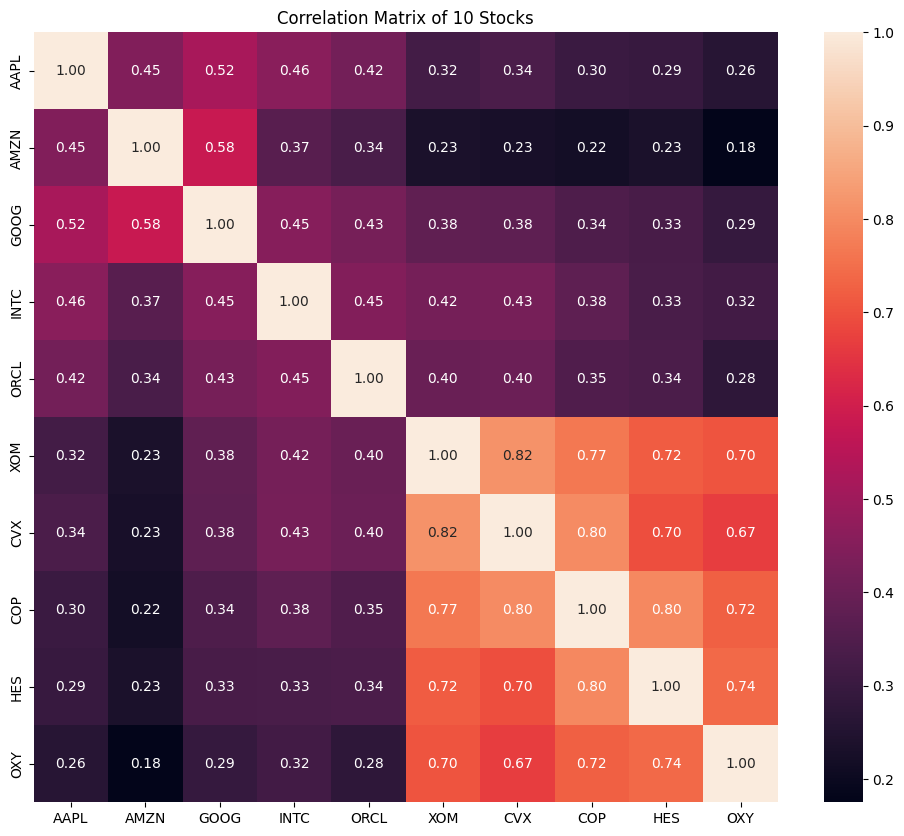

In [11]:
# In order to look at the correlation for the stock dailiy return, we are intested in both the pearson correlation and the Cross-correlation
# based the natural of time series.

# First calculate the log return of all the 10 stocks:
log_returns = np.log(close_df / close_df.shift(1))[1:]

# pearson correlation:
correlation_matrix = log_returns.corr(method='pearson')
plt.figure(figsize=(12, 10))  # Set the size of the figure
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cbar=True) # correlation heatmap
plt.title('Correlation Matrix of 10 Stocks')
plt.show()

In [39]:
#cross-correlation at different lag
# Dickey-Fuller for test the stationarity, which is one of the assumptions for cross-correlation
def stationarity_tests(dataframe):
    results = {}
    for column in dataframe.columns:
        adf_test = adfuller(dataframe[column])
        results[column] = {
            'p-value': adf_test[1],
            'Stationary': adf_test[1] < 0.05
        }
    return pd.DataFrame(results).T

# Test result
display(stationarity_tests(log_returns).style.set_caption("Stationarity Test"))

,p-value,Stationary
AAPL,0.000000,True
AMZN,0.000000,True
GOOG,0.000000,True
INTC,0.000000,True
ORCL,0.000000,True
XOM,0.000000,True
CVX,0.000000,True
COP,0.000000,True
HES,0.000000,True
OXY,0.000000,True


Cross-Correlation Matrix


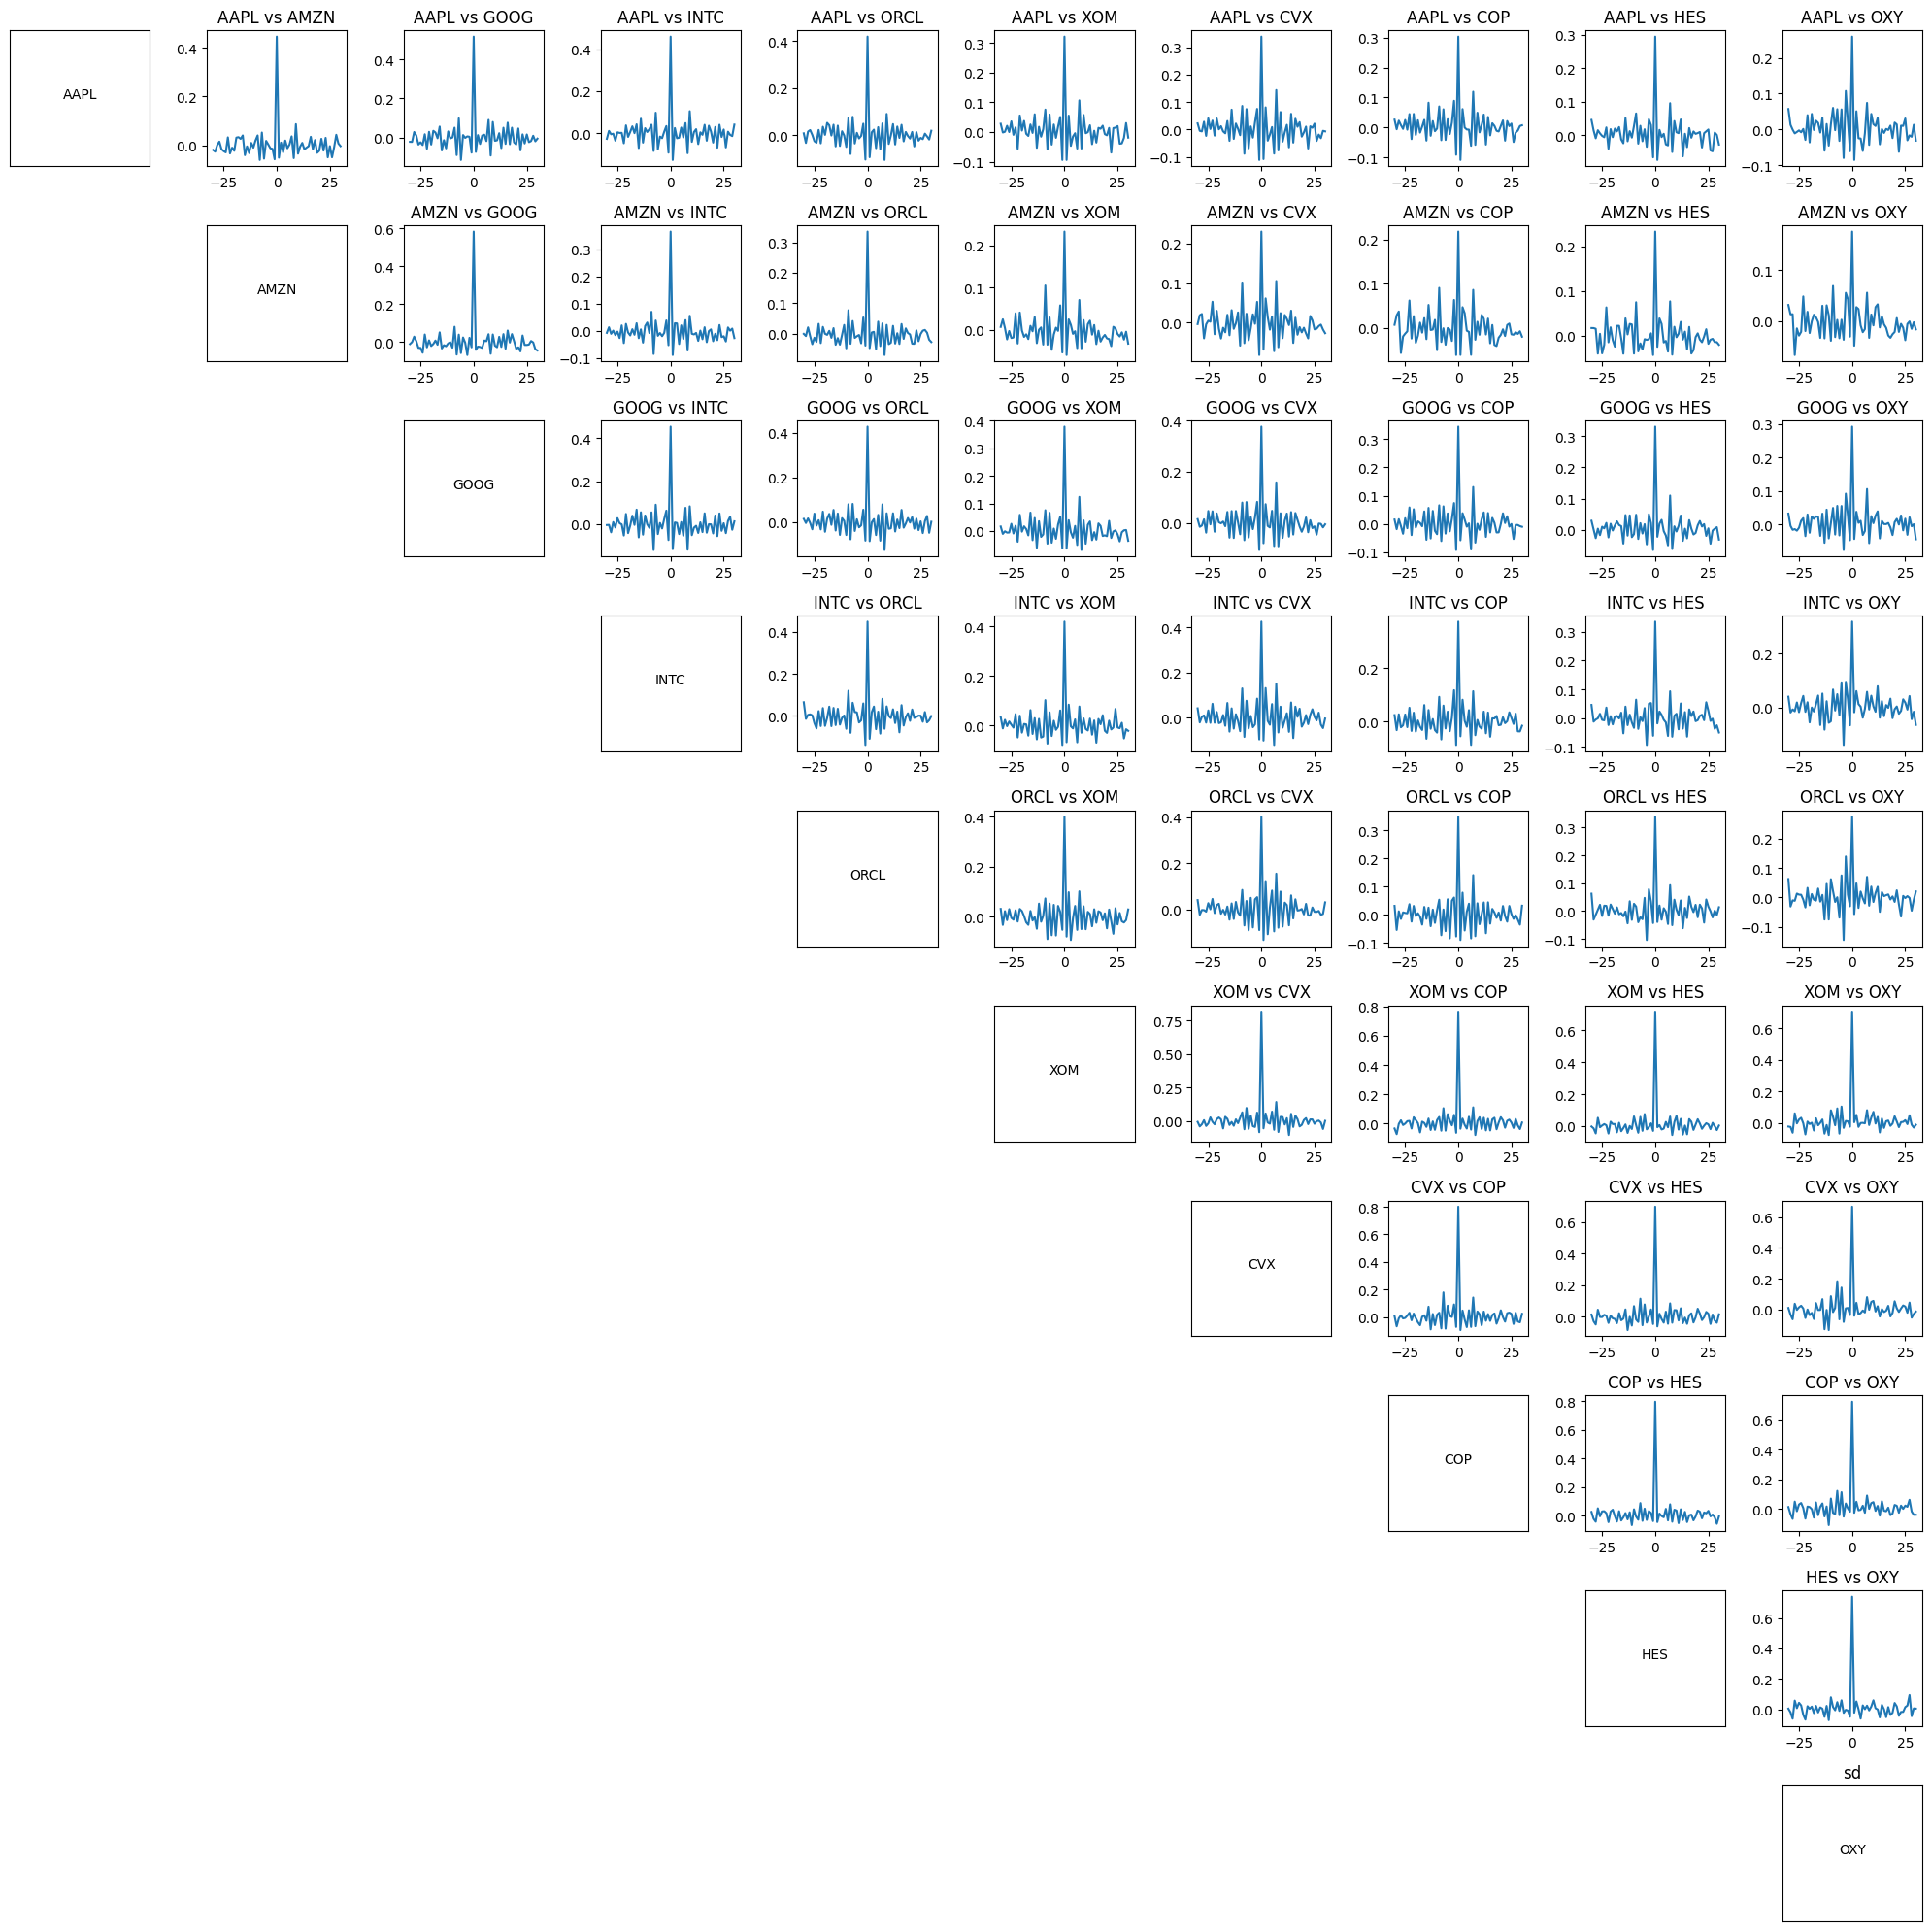

In [50]:
print('Cross-Correlation Matrix')
# From the above results, we can assume that the 2012~2021 data is stationery. And we can try look into the cross-correlation
def plot_cross_correlation(dataframe):
    n = len(dataframe.columns)
    fig, axes = plt.subplots(n, n, figsize=(20, 20))
    for i, col1 in enumerate(dataframe.columns):
        for j, col2 in enumerate(dataframe.columns):
            if i >= j:
                axes[i, j].xaxis.set_visible(False)
                axes[i, j].yaxis.set_visible(False)
                if i == j:
                    axes[i, j].text(0.5, 0.5, col1, ha='center')
                continue
            cross_corr = pd.Series([dataframe[col1].shift(lag).corr(dataframe[col2]) for lag in range(-30, 31)])
            axes[i, j].plot(range(-30, 31), cross_corr)
            axes[i, j].set_title(f'{col1} vs {col2}')
            axes[j, i].set_visible(False) # Hide lower triangle for redundancy

    plt.tight_layout()
    plt.show()

# Cross Correlation Plot result

plot_cross_correlation(log_returns)

# Answer
From the Correlation Matrix:
 XOM, CVX, COP, HES, and OXY are highly positively correlated with each other and there are companies from the energy sector. Especially for the XOM and CVX which are the giants in gas and oil show a particularly strong positive correlation, indicating they move together.
 For the Tech stocks, Apple and Google, Amazon and Google show moderate correlations with each other, suggesting some level of synchronous movement but with less intensity. The correlation of Oracle and Intel with other tech stocks is even slight. In the tech sector, the correlation within the sector is less significant compared with the energy companies.
 For the correlation across sectors, we only observe that intel has a slightly higher correlation with CVX and XOM. This might be because Intel as a chip company, has a potentially higher connection to the energy sector, but this relationship is not significant enough.


From the corss-correlation plots:
The cross-correlation plots generally indicate that there is little to no lead-lag relationship between the stock pairs; the movements are mostly simultaneous as indicated by the clustering around zero lag and close to zero in different lag days.

Overall, the correlation shows that there exists industry-based clustering in stock movements and does not have strong evidence of predictable lead-lag relationships between different stocks. However, these results are also limited by the time frame of the stock so we need to consider it differently based on if we want to do short-term or long-term investment.

# Q4
A colleague of yours is curious whether the 10 stocks exhibited similar behaviour during the pandemic. You think that the performance was different across two groups of stocks. Generate quarterly returns over this period for all 10 stocks. Perform a K-means clustering with two groups using quarterly returns from Q2 2020 to Q4 2021 (7 features for each stock) for each of the 10 stocks. Comment on your findings.

,AAPL,AMZN,GOOG,INTC,ORCL,XOM,CVX,COP,HES,OXY
Date,,,,,,,,,,
2020-06-30,0.434583,0.414983,0.215684,0.105506,0.143596,0.177772,0.231438,0.364286,0.555856,0.580311
2020-09-30,0.269847,0.141332,0.039608,-0.134548,0.080152,-0.232335,-0.193097,-0.218467,-0.209998,-0.453005
2020-12-31,0.145756,0.034363,0.192079,-0.037852,0.083585,0.200699,0.172917,0.217722,0.289763,0.729271
2021-03-31,-0.079433,-0.050001,0.180806,0.284625,0.084712,0.354440,0.240853,0.324581,0.340405,0.537839
2021-06-30,0.121244,0.111852,0.211584,-0.122813,0.109306,0.129858,-0.000477,0.149707,0.234030,0.174681
2021-09-30,0.033148,-0.045091,0.063436,-0.050944,0.119347,-0.067533,-0.031411,0.112808,-0.105474,-0.054045
2021-12-31,0.259364,0.026742,0.095576,-0.028904,0.010100,0.033492,0.157516,0.066549,-0.053130,-0.020622


,0,1,2,3,4,5,6,7,8,9
Stock,AAPL,AMZN,GOOG,INTC,ORCL,XOM,CVX,COP,HES,OXY
Cluster,1,1,1,1,1,1,1,1,0,0


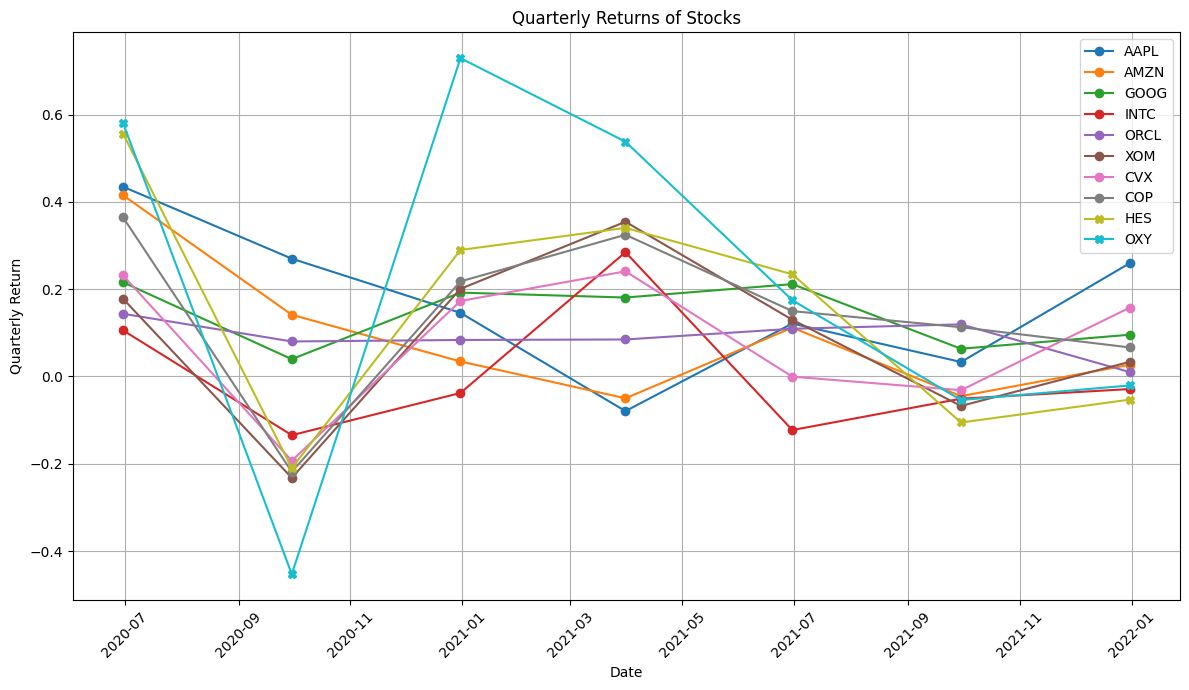

In [57]:
# For cross-sectional study, I will use the simple return as the calculation of the features.
# (It is also doable to sum up the daily log-return to achieve the quartly return)

# Quartly return
quarterly_prices = close_df.resample('Q').last()
quarterly_simple_returns = quarterly_prices.pct_change()
period_returns = quarterly_simple_returns.loc['2020-06-30':'2021-12-31'] # Filter the DataFrame for the period from Q2 2020 to Q4 2021
display(period_returns)
# K-means clustering
X = period_returns.T
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) # Scale the data for K-means
kmeans = KMeans(n_clusters=2, random_state=2001,n_init=10).fit(X_scaled)# Perform K-means clustering
cluster_labels = kmeans.labels_ # label results
results_df = pd.DataFrame({'Stock': X.index, 'Cluster': cluster_labels}) # results for K-means
display(results_df.T.style.set_caption("Clustering Results"))

# deep dive into the results by time series data of the stocks HES and OXY
# Plotting
plt.figure(figsize=(12, 7))
for column in period_returns.columns:
    if column in ['OXY', 'HES']:
      plt.plot(period_returns.index, period_returns[column], marker='X', label=column)
    else:
      plt.plot(period_returns.index, period_returns[column], marker='o', label=column)
plt.title('Quarterly Returns of Stocks')
plt.xlabel('Date')
plt.ylabel('Quarterly Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Answer 
After standardizing the data, the clustering results suggest that stocks AAPL, AMZN, GOOG, INTC, ORCL, XOM, CVX, and COP are grouped in one cluster (Cluster 1), while HES and OXY are grouped into another cluster (Cluster 0). This outcome implies that each cluster of stocks has similar performance metrics or characteristics over the quarterly return during the pandemic.

If we take a look at the return plots, these results can be caused by the extremely lower return and high return shifted from 2020 Q3 to 2021 Q1 of the stock OXY and HES which contributes to the clustering results. Energy sector stocks (HES, OXY) are more volatile as indicated by the larger fluctuations in their quarterly values. In general, we might need to consider more clusters for this study for a further look. For example, the behaviour of Apple and Amazon are similar but different from other stocks during this period. And we need more data to do the actual grouping. 

# Q5
You are deciding how to weight the 10 stocks in creating a suitable portfolio. Calculate the set of optimal portfolio weights across the 10 stocks such that you minimize the variance of portfolio returns. Comment on the optimal portfolio weights and potential issues.


Optimal Weights: [1.29291353e-01 2.48221772e-01 9.27530786e-02 3.06096200e-02
 2.25337844e-01 7.02170666e-02 2.03569266e-01 6.28837260e-18
 0.00000000e+00 0.00000000e+00]
optimal_var_portfolio 0.00010254429181246589


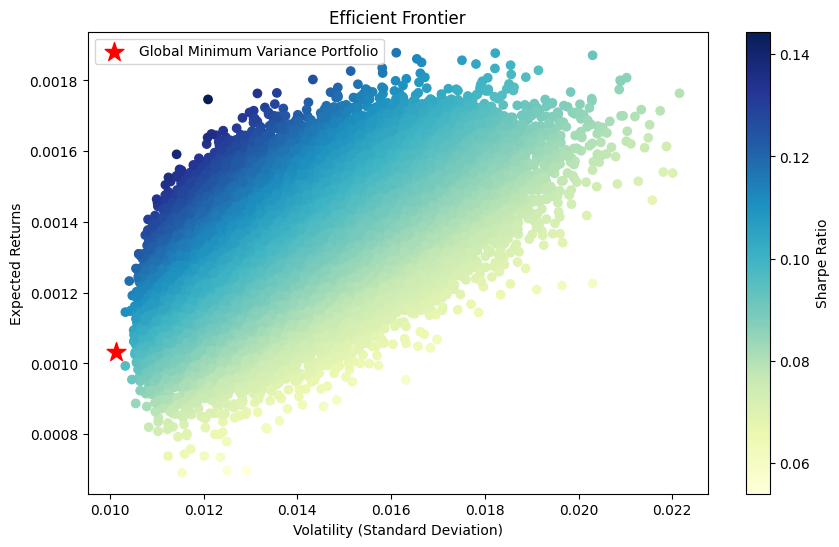

In [180]:




## Simulation Steps
# Calculate expected returns and covariance
log_return_2021 = log_returns.loc['2021-01-01':'2021-12-31']
expected_returns = log_return_2021.mean()
cov_matrix = log_return_2021.cov()
# Number of assets and portfolios
n_assets = len(expected_returns)
n_portfolios = 100000
# Containers for portfolio metrics
portfolio_returns = []
portfolio_risks = []
portfolio_weights = []
# Simulate portfolios and calculate performance metrics
for _ in range(n_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    portfolio_weights.append(weights)

    returns = np.dot(weights, expected_returns)
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    risk = np.sqrt(variance)

    portfolio_returns.append(returns)
    portfolio_risks.append(risk)

# Convert to arrays for plotting
portfolio_returns = np.array(portfolio_returns)
portfolio_risks = np.array(portfolio_risks)

# Pick the Ininitial Guess
index_min_variance = np.argmin(portfolio_risks)


## Optimization

# Define the objective function (portfolio variance)
def portfolio_variance(weights, covariance_matrix):
    return weights.T @ covariance_matrix @ weights
# The number of assets
n_assets = 10
# Modified initial guess based on the simulation results
np.random.seed(100)  #  reproducibility
initial_guess = np.random.random(n_assets)
initial_guess /= np.sum(initial_guess)
initial_guess = portfolio_weights[index_min_variance]

# The constraint that the sum of weights equals 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
# The bounds for each weight (between 0 and 1)
bounds = tuple((0, 1) for asset in range(n_assets))
# Minimize the portfolio variance
result = minimize(portfolio_variance, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, 
                  constraints=constraints,options={'disp': False, 'maxiter': 1000, 'ftol': 1e-09} )

if result.success:
    optimal_weights = result.x
    print("Optimal Weights:", optimal_weights)
    print("optimal_var_portfolio",portfolio_variance(optimal_weights, cov_matrix))
else:
    raise ValueError("No solution found")

## plotting
# Step 5: Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_returns / portfolio_risks, cmap='YlGnBu', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

# Step 6: Highlight the GMVP
plt.scatter(np.sqrt(portfolio_variance(optimal_weights, cov_matrix)), np.dot(optimal_weights, expected_returns), color='red', marker='*', s=200, label='Global Minimum Variance Portfolio')
plt.legend(labelspacing=0.8)

plt.show()

In [187]:
weights = np.random.random(n_assets)
weights /= np.sum(weights)
sum(weights)

1.0

In [201]:
# outline of my procedure:
# 1. Using Monte Carlo simulation to decide a proper initial guess for the optimization
# 2. Optimizing to obtain the minimum variance portfolio
# 3. Plotting the optimized value with the simulated results

class GMVP_PortfolioOptimizer:
    """
    A class for optimizing a portfolio of assets based on GMVP
    
    Attributes:
        log_returns: DataFrame of historical log returns for each asset.
        expected_returns: Array of expected returns for each asset.
        cov_matrix: Covariance matrix of asset returns.
        portfolio_weights: List of weights for each simulated portfolio.
        portfolio_returns: Array of returns for each simulated portfolio.
        portfolio_risks: Array of std for each simulated portfolio.
        optimal_weights: Array of weights for the optimized portfolio.
        optimal_Variance : GMVP
        simulator: Number of simulation for initial value
    """
    def __init__(self, log_returns):
        self.log_returns = log_returns
        self.expected_returns = None
        self.cov_matrix = None
        self.portfolio_weights = []
        self.portfolio_returns = []
        self.portfolio_risks = []
        self.optimal_weights = None
        self.optimal_Variance = None
        self.simulator = 100000 # number of simulation for initial value

    def calculate_expected_returns_and_covariance(self, start_date, end_date):
        log_return_period = self.log_returns.loc[start_date:end_date] 
        self.expected_returns = log_return_period.mean()
        self.cov_matrix = log_return_period.cov()

    def simulate_portfolios(self, simulators):
        '''
        simulate random portfolio in order to pick the initial guess in the actual optimization
        '''
        n_assets = len(self.expected_returns) # number of assets
        for _ in range(simulators):
            weights = np.random.random(n_assets)
            weights /= np.sum(weights)
            self.portfolio_weights.append(weights)
            # calculate the return and variance(risk)
            returns = np.dot(weights, self.expected_returns)
            variance = np.dot(weights.T, np.dot(self.cov_matrix, weights))
            risk = np.sqrt(variance)

            self.portfolio_returns.append(returns)
            self.portfolio_risks.append(risk)

        self.portfolio_returns = np.array(self.portfolio_returns)
        self.portfolio_risks = np.array(self.portfolio_risks)

    def G_minimum_variance_portfolio(self):
        '''
        Optimize the objective function to get GMVP with the initial guess from the simulation result
        '''
        # using the optimized results in the simulation run as the initial guess
        index_min_variance = np.argmin(self.portfolio_risks)
        initial_guess = self.portfolio_weights[index_min_variance]

        # objective function
        def portfolio_variance(weights, covariance_matrix):
            return weights.T @ covariance_matrix @ weights

        # constraints and bounds
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        bounds = tuple((0, 1) for asset in range(len(self.expected_returns)))

        result = minimize(portfolio_variance, initial_guess, args=(self.cov_matrix,), method='SLSQP', bounds=bounds, 
                          constraints=constraints, options={'disp': False, 'maxiter': 1000, 'ftol': 1e-09})
        self.optimal_weights = result.x
        self.optimal_Variance = portfolio_variance(self.optimal_weights,self.cov_matrix)

    def plot_efficient_frontier(self):
        ''' 
        Plot the simulation results as well as the optimized portfolio
        '''
        plt.figure(figsize=(10, 6))
        # Assume risk-free rate is 0 to plot the sharp ratio
        plt.scatter(self.portfolio_risks, self.portfolio_returns, c=self.portfolio_returns / self.portfolio_risks, cmap='YlGnBu', marker='o')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Risk (Standard Deviation)')
        plt.ylabel('Expected Return')
        plt.title('EF (simulation run)')

        GMVP_risk = np.sqrt(portfolio_variance(self.optimal_weights, self.cov_matrix))
        GMVP_var_return = np.dot(self.optimal_weights, self.expected_returns)
        plt.scatter(GMVP_risk, GMVP_var_return, color='blue', marker='X', s=150, label='GMVP')
        plt.legend(labelspacing=0.8)

        plt.show()

    def optimize_portfolio(self, start_date, end_date, simulator=100000):
        self.calculate_expected_returns_and_covariance(start_date, end_date)
        self.simulate_portfolios(simulator)
        self.G_minimum_variance_portfolio()
        return self.optimal_weights, self.optimal_Variance


,Weight
AAPL,0.111936
AMZN,0.214495
GOOG,0.116240
INTC,0.052164
ORCL,0.224047
XOM,0.034705
CVX,0.246414
COP,0.000000
HES,0.000000
OXY,0.000000


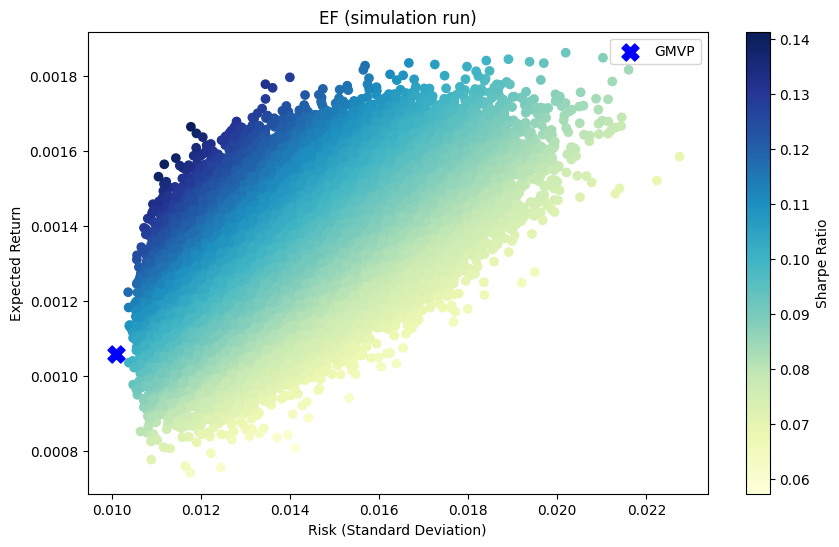

The GMVP has variance: 0.00010181880654784931


In [209]:
# Return the results
optimizer = GMVP_PortfolioOptimizer(log_returns)
optimal_weights,optimal_Variance = optimizer.optimize_portfolio('2021-01-01', '2021-12-31')
portfolio_weights_df = pd.DataFrame(optimal_weights, index=log_returns.columns, columns=['Weight'])
display(portfolio_weights_df.style.set_caption("GMVP"))
optimizer.plot_efficient_frontier()
print('The GMVP has variance:',optimal_Variance)